# paper-plot_kw-spectra
plot $(k,\omega)$ spectra, 1 simu, 1 season and ratio, 1 or several depths <br/>
for paper, adapted from plot_kw-spectra.ipynb

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 12

import numpy as np
from netCDF4 import Dataset
import os, sys
import scipy.interpolate as itp
if "/home/lahaye/Coding/python_science" not in sys.path:
    sys.path.append("/home/lahaye/Coding/python_science")
import colormaps as cm

krypton = "/data0/project/vortex/lahaye/"
ruchba = "/net/ruchba/local/tmp/2/lahaye/"


In [2]:
# useful functions
def IWdisprel(kk, nmod=1, N=3e-3, H=2.5, f=8.85e-5):
    """ relation dispersion for internal waves, k and H in km, N and f in s-1
    returns omega in cpd """
    return np.sqrt((N*kk/nmod/np.pi*H)**2 + f**2)*3600*24/2/np.pi


def bleacher(color, alpha):
    return alpha[:,None] * color + (1 - alpha[:,None])

In [18]:
# Parameters

simul = "luckyt"
season = "summer" #"summer" # 
what = "SSH" #"UVDIV"
izds = [0] #[0., -500.] #   # niteger -> index, float -> depth will not be used if what=="SSH"

dosavefig = False
dirpic = "pictures/paper_figs/"

path_data = ruchba+"data_from_Irene/kw_spectra/"
path_spec = path_data+"{0}_kw-spec_{1}_{2}.nc".format(simul,what,season[:3])

# plotting parameters
cmap = plt.get_cmap('nipy_spectral')
gcol = "w"
alpha = 0.6 # alpha for additional lines

norm = "1/dk/df"  # if renormalization is needed (kw-spectra prior to 27 November 2018)

# various parameters
fcor, fcin, fcax = 8.85e-5, 8.62e-5, 9.08e-5 # coriolis at (center, 1/4, 3/4) [rad/s]
Hmoy = 2.5   # km
nmods = [1, 2, 3, 10, 20]  # modes dispersion curve to show
dx, Lx = 0.750, 1500 # horizontal resolution model
fmin = 2./7 # min frequency to show, in cpd

#lscal = [10, 100]    # typical lengthscales (km) to show
fscal = [11.96, 12.42, 12.42/2., (2*np.pi/fcor)/3600] # typical time scale (in hour)
flabs = [r'$S_2$', r'$M_2$', r'$2 M_2$', r"$f$"]

## Plots of HKE or SSH at different depths

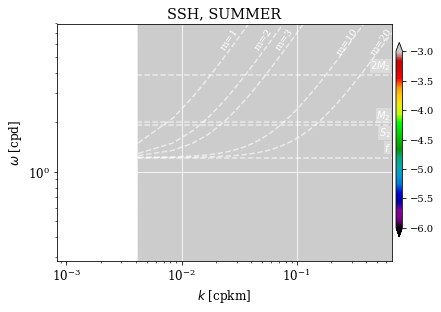

In [19]:
# load and plot
fmax = np.inf
titi = '{0}, {1}'.format(what.upper(), season.upper())
if what == "SSH": 
    vmin, vmax = -6, -3
else:
    vmin, vmax = -3, 2

fig, axs = plt.subplots(1, len(izds), sharex=True, sharey=True \
                        , figsize=(5*len(izds)+1,4.5))
if len(izds)==1: axs = np.array([axs])

for ii,izd in enumerate(izds):
    ax = axs[ii]
    nc = Dataset(path_spec, "r")
    kk = nc.variables['k'][:]
    Nx, dk = len(kk)*2, np.diff(kk)[0]
    freq = nc.variables['freq'][:]
    Nt, df = len(freq)*2+1, np.diff(freq)[0]
    if what in ["SSH"] or isinstance(izd,str):
        spec = nc.variables["spectrum"][:]
    else:
        if isinstance(izd, int):
            iz = izd
        elif isinstance(izd, float):
            depth = nc.variables["depths"][:]
            iz = abs(depth-izd).argmin()
        spec = nc.variables["spectrum"][iz,:,:]
        depth = nc.variables['depths'][iz]
        print("index = {0}, depth={1}, asked {2}".format(iz,depth,izd))
    nc.close()
    spec *= eval(norm)*kk[None,:]*freq[:,None] # renormalization
    kpl = kk[1:]#/2/np.pi # cpkm
    fpl = freq[1:] * 24 # cpd
    fmax = min(fmax,freq.max())
    hpc = ax.pcolormesh(kpl, fpl, np.log10(spec[1:,1:]), vmin=vmin, vmax=vmax, cmap=cmap, shading="gouraud")

    for nmod in nmods:
        ax.plot(kpl, IWdisprel(kpl*2*np.pi, nmod=nmod), '--w', alpha=alpha)
        ix = abs(IWdisprel(kpl*2*np.pi, nmod)-fmax*24).argmin()
        ax.text(kpl[ix]/1.8, fmax*21, r"m={}".format(nmod), rotation=55, fontsize=10, color="w")# \
               # , bbox=dict(facecolor="w", edgecolor="none", alpha=.3, pad=.1))
    for ll,la in zip(fscal,flabs):
        ax.axhline(24./ll, linestyle='--', color='w', alpha=alpha)
        vshift = 0.82 if la==r'$S_2$' else 1.09
        ax.text(.49/dx, vshift*24./ll, la, fontsize=10, ha="right", color="w" \
                , bbox=dict(facecolor="w", edgecolor="none", alpha=.3, pad=.2))
    if len(izds)>1:
        letit = titi + " -- z={}m".format(int(depth))
    else:
        letit = titi
    ax.set_title(letit)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1.25/Lx, .5/dx])
#ax.set_ylim([fcor/2/np.pi*3600*24,fmax*24])
ax.set_ylim([fmin,fmax*24])
for ax in axs.ravel():
    ax.grid(color=gcol)    
    ax.set_xlabel(r'$k$ [cpkm]')
axs[0].set_ylabel(r'$\omega$ [cpd]')

fig.tight_layout()

#ftit = r'WKB amp -- ratio {0}/{1} m'.format(int(depths[0]),int(depths[1]))
#fig.suptitle(ftit, y=1.00)

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.25, 0.015, 0.6])
ac = plt.colorbar(hpc, cax=cbar_ax, extend="both")
ac.ax.tick_params(labelsize=10)
#ac.set_label(what+' (log)')

if dosavefig:
    fig.savefig(dirpic+"{0}_kw-spec_{1}_{2}.png".format(simul,what,season[:3]) \
               , magnification="auto", dpi=200, bbox_inches="tight")

## Part 2: summer/winter ratio

In [29]:

what = "SSH"
iz = 0 # will be ignored if what == "SSH"

vmin, vmax = -1.5, 1.5
cmap = cmap = cm.dark_redblue(rev=True,coef=0.25)
alrange = -2.5, -1
if what == "SSH":
    alrange = alrange[0]-1.5, alrange[1]-1.5

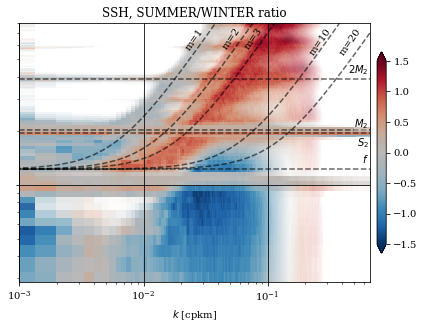

In [30]:
fig= plt.figure(figsize=(6,4.5))
ax = plt.gca()

season = ['summer','winter']
kk, freq, spec = {}, {}, {}
for isea,sea in enumerate(season):
    path_spec = path_data+"{0}_kw-spec_{1}_{2}.nc".format(simul,what,sea[:3])
    nc = Dataset(path_spec, "r")
    kk[sea] = nc.variables['k'][1:]
    freq[sea] = nc.variables['freq'][1:] * 24
    if what in ["SSH"] or isinstance(iz,str):
        spec[sea] = nc.variables["spectrum"][1:,1:]
    else:
        spec[sea] = nc.variables["spectrum"][iz,1:,1:] 
        depth = nc.variables["depths"][iz]  
    nc.close()
    
# interpolate if necessary
k1, k2 = [kk[sea].copy() for sea in season]
spec1, spec2 = [spec[sea].copy() for sea in season]
if len(k1) == len(k2) and np.allclose(k1, k2):
    kk = k1
elif len(k1) <= len(k2):
    kk = k1
    spec2 = itp.interp1d(k2, spec2, axis=1)(k1)
else:
    kk = k2
    spec1 = itp.interp1d(k1, spec1, axis=1)(k2)
fr1, fr2 = [freq[sea].copy() for sea in season]
if len(fr1) == len(fr2) and np.allclose(fr1, fr2):
    freq = fr1
elif len(fr1) <= len(fr2):
    freq = fr1
    spec2 = itp.interp1d(fr2, spec2, axis=0)(fr1)
else:
    freq = fr2
    spec1 = itp.interp1d(fr1, spec1, axis=0)(fr2)

specrat = spec1/spec2
specmax = np.where(spec1>spec2, spec1, spec2)
fmax = freq.max()

kpl = kk/2/np.pi

hpc = ax.pcolormesh(kpl, freq, np.log10(specrat), vmin=vmin, vmax=vmax \
                        , cmap=cmap, shading="flat", edgecolor=None)

for nmod in nmods:
    ax.plot(kpl, IWdisprel(kk, nmod=nmod), '--k', alpha=alpha)
    ix = abs(IWdisprel(kk, nmod)-fmax).argmin()
    ax.text(kpl[ix]/1.8, fmax*21./24, r"m={}".format(nmod), rotation=55, fontsize=10)# \
                   # , bbox=dict(facecolor="w", edgecolor="none", alpha=.3, pad=.1))
for ll,la in zip(fscal,flabs):
    ax.axhline(24./ll, linestyle='--', color='k', alpha=alpha)
    vshift = 0.82 if la==r'$S_2$' else 1.09
    ax.text(.49/dx, vshift*24./ll, la, fontsize=10, ha="right" \
                    , bbox=dict(facecolor="w", edgecolor="none", alpha=.3, pad=.2))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1.5/Lx, .5/dx])
ax.set_ylim([fmin,fmax])    
ax.grid(True, color="k")
ax.set_xlabel(r'$k$ [cpkm]')
#ax.set_ylabel(r'$\omega$ [cpd]')
ax.set_yticklabels([])

ac = plt.colorbar(hpc, ax=ax, extend="both", fraction=.025, pad=.02)

fig.tight_layout()

alphas = (np.clip(np.log10(specmax[1:,1:]), alrange[0], alrange[1])-alrange[0])/(alrange[1]-alrange[0])
fig.canvas.draw()
colors = hpc.get_facecolor()[:,:3]
hpc.set_facecolor(bleacher(colors, alphas.ravel()))
fig.canvas.draw()

ax.set_title(what.upper()+", SUMMER/WINTER ratio")

if dosavefig:
        fig.savefig(dirpic+"{0}_kw-spec-ratio_{1}_SUMoWIN.png".format(simul,what) \
               , magnification="auto", dpi=200, bbox_inches="tight")